In [1]:
!pip install pydantic
!pip install langchain
!pip install langgraph
!pip install langchain-core
!pip install langchain-community
!pip install langchain-groq
!pip install arxiv
!pip install wikipedia

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 5.6 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requ

In [19]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_groq import ChatGroq
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display

In [5]:
arxiv_wrapper = ArxivAPIWrapper(top_k_results = 1, doc_content_chars_max = 500)
arxiv = ArxivQueryRun(api_wrapper = arxiv_wrapper)

wiki_wrapper = WikipediaAPIWrapper(top_k_results = 1, doc_content_chars_max = 500)
wikipedia = WikipediaQueryRun(api_wrapper = wiki_wrapper)

tavily = TavilySearchResults(max_results = 1, tavily_api_key = "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")

In [6]:
tools = [arxiv, wikipedia, tavily]

In [8]:
llm = ChatGroq(model = "qwen/qwen3-32b", groq_api_key = "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")

In [9]:
llm_with_tools = llm.bind_tools(tools)

In [14]:
class State(TypedDict):
  messages: Annotated[list[AnyMessage], add_messages]

In [15]:
def tool_calling_llm(state: State):
  return {"messages": [llm_with_tools.invoke(state["messages"])]}

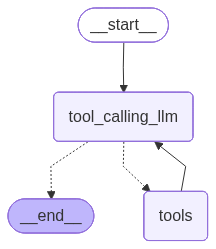

In [21]:
builder = StateGraph(State)

builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm", tools_condition)
builder.add_edge("tools", "tool_calling_llm")

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [36]:
while True:
  query = input("You: ")
  if query.lower() == "exit":
    print("Goodbye")
    break
  else:
    messages = graph.invoke({"messages": query})
    print(messages)
    for m in messages["messages"]:
      m.pretty_print()

You: hi how are you?
{'messages': [HumanMessage(content='hi how are you?', additional_kwargs={}, response_metadata={}, id='2273b9ed-102e-4b9b-8073-9a75128d63bd'), AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'reasoning_content': 'Okay, the user asked "hi how are you?" which is a greeting. I need to respond appropriately. Since there\'s no specific question here that requires using the provided tools (arxiv, wikipedia, tavily_search), I should just reply with a friendly greeting. Let me check the functions again to make sure. The tools are for answering questions about scientific articles, general knowledge, and current events. A simple hello doesn\'t need any of those. So I\'ll respond with a hello and offer assistance.\n'}, response_metadata={'token_usage': {'completion_tokens': 116, 'prompt_tokens': 398, 'total_tokens': 514, 'completion_time': 0.250935108, 'prompt_time': 0.025425841, 'queue_time': 0.215145384, 'total_time': 0.276360949}, 'model_name': 'q